### Goal

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import scipy.stats as stats
import pandas as pd

import matplotlib.pyplot as plt

### TODO: update this path

In [3]:
root = "/Users/michaelmoret/tinyverse/krap/data/24-12-06/single/"

### From here; automatic run

In [4]:
for file in os.listdir(root):
    if file.endswith(".txt"):
        print(file)

20241206$25^EN_IHNY_bleached_ control_locx$25^positive_5_LocxEF$25^positive_1_LOcxEF$25^negative_2$single.txt
20241206$25^EN_IHNY_bleached_ locx_NAC_positive$25^3_Locx NAC_negative$25^4_LOcx_negative_6$single.txt.txt


In [5]:
savepath = f"{root}plots/"
os.makedirs(savepath, exist_ok=True)

In [6]:
all_dfs = []
for file in os.listdir(root):
    if file.endswith(".txt"):
        df = pd.read_csv(root + file, sep="\t")
        splitted_name = file.split("$")
        # get the experiments; i.e. not the date
        # not the single or triple
        splitted_name = splitted_name[1:-1]
        # add the experiment name in the dataframe
        all_names = []
        for entries in splitted_name:
            times_name = entries.split("^")
            _times = int(times_name[0])
            _name = times_name[1]
            all_names += [_name] * _times
        df["Name"] = all_names
        # remove nan
        df = df.dropna()
        all_dfs.append(df)
        
# merge df
df_merged = pd.concat(all_dfs)
df_merged.head(5)

,RECORD,MEAN AREA,ESTIMATED_LENGTH(*),GRADIENT(*),EMOD(*)(#),DECRIMPING_WORK,EXTENSION_WORK,START_X(*),START_Y,END_X(*),END_Y,ANALYSIS_WORK,BREAK_STRAIN(*)(#),BREAK_LOAD,TENSILE_STRENGTH,Name
0,1,4385.4,29.98,-0.000709,-4.850000e+06,0.000000e+00,0.012280,0.2001,6.488,0.8005,6.488,0.000005,63.276,0.9075,206.9,EN_IHNY_bleached_ control_locx
1,2,3868.2,30.26,0.669200,5.235000e+09,3.115000e-07,0.007983,0.2644,19.280,0.8592,51.100,0.000024,47.323,0.7574,195.8,EN_IHNY_bleached_ control_locx
2,3,4399.2,30.55,0.703200,4.883000e+09,4.219000e-07,0.007377,0.2619,18.290,0.8183,45.940,0.000025,42.455,0.7172,163.0,EN_IHNY_bleached_ control_locx
3,4,3192.7,30.40,0.535100,5.095000e+09,0.000000e+00,0.008829,0.2303,20.130,0.8553,51.320,0.000022,58.717,0.6828,213.9,EN_IHNY_bleached_ control_locx
4,5,2545.4,30.68,0.485100,5.847000e+09,0.000000e+00,0.005912,0.2934,25.820,0.8149,55.690,0.000017,49.087,0.5435,213.5,EN_IHNY_bleached_ control_locx


## Helper Functions

In [7]:
import matplotlib.pyplot as plt
import scipy.stats
from itertools import combinations
import numpy as np

def create_boxplot(df, metric_column, group_column='Name', figsize=(10, 6)):
    """Create a compact boxplot with statistical test and median values"""
    
    # Create plot
    fig, ax = plt.subplots(figsize=figsize)
    
    # Function to remove outliers
    def remove_outliers(data):
        Q1 = np.percentile(data, 25)
        Q3 = np.percentile(data, 75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        return data[(data >= lower_bound) & (data <= upper_bound)]
    
    # Get unique base names and assign colors
    base_names = [name.split('*')[0] for name in df[group_column].unique()]
    unique_base_names = list(dict.fromkeys(base_names))  # Preserve order
    colors = plt.cm.Set3(np.linspace(0, 1, len(unique_base_names)))
    color_dict = dict(zip(unique_base_names, colors))
    
    # Create boxplot
    bp = ax.boxplot([df[df[group_column] == group][metric_column] for group in df[group_column].unique()],
                    patch_artist=True,
                    medianprops={'color': 'red', 'linewidth': 1.5},
                    boxprops={'color': 'black'},
                    whiskerprops={'color': 'black'},
                    capprops={'color': 'black'},
                    showfliers=False)
    
    # Color the boxes
    for patch, group_name in zip(bp['boxes'], df[group_column].unique()):
        base_name = group_name.split('*')[0]
        patch.set_facecolor(color_dict[base_name])
        patch.set_alpha(0.7)
    
    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Get unique groups
    group_names = df[group_column].unique()
    
    # Add median values and set x-tick labels
    ax.set_xticklabels(group_names, rotation=45, ha='right')
    
    for i, group in enumerate(group_names):
        median = df[df[group_column] == group][metric_column].median()
        ax.text(i+1, ax.get_ylim()[1]*1.02, f'Median: {round(median, 2)}',
                horizontalalignment='center', fontsize=9)
    
    # Perform pairwise Mann-Whitney U tests
    pairs = list(combinations(group_names, 2))
    
    for group1_name, group2_name in pairs:
        group1_data = df[df[group_column] == group1_name][metric_column]
        group2_data = df[df[group_column] == group2_name][metric_column]
        
        group1_clean = remove_outliers(group1_data)
        group2_clean = remove_outliers(group2_data)
        
        stat, p_value = scipy.stats.mannwhitneyu(group1_clean, group2_clean, alternative='two-sided')
        if p_value < 0.05:
            print(f"Statistical significance between {group1_name} and {group2_name}: p = {p_value:.4f}")
    
    plt.suptitle('')
    plt.title('')
    plt.xlabel(group_column, fontsize=10)
    plt.ylabel(metric_column.replace('_', ' ').title(), fontsize=10)
    ax.yaxis.grid(True, linestyle='--', alpha=0.3)
    
    plt.tight_layout()
    
    return fig, ax

Statistical significance between EN_IHNY_bleached_ control_locx and EN_IHNY_bleached_ locx_NAC_positive: p = 0.0445
Statistical significance between EN_IHNY_bleached_ control_locx and 4_LOcx_negative_6: p = 0.0469
Statistical significance between positive_1_LOcxEF and EN_IHNY_bleached_ locx_NAC_positive: p = 0.0284
Statistical significance between positive_1_LOcxEF and 4_LOcx_negative_6: p = 0.0356


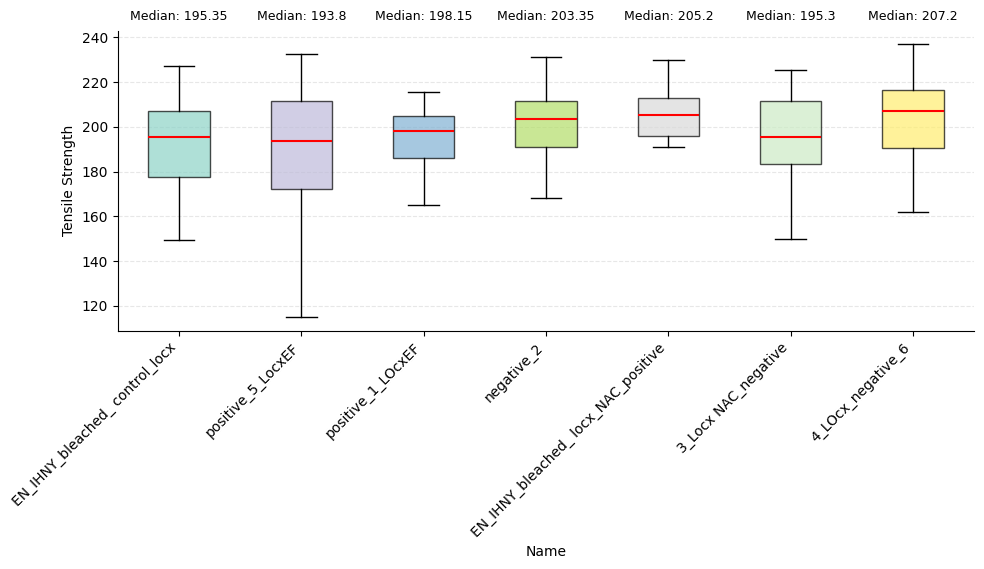

In [8]:
header = 'TENSILE_STRENGTH'
fig, ax = create_boxplot(df_merged, header)
fig.savefig(f"{savepath}{header}.png")
plt.show()

Control check

In [9]:
unique_names = df_merged['Name'].unique()
for name in unique_names:
    median_tensile_strength = df_merged[df_merged['Name'] == name]['TENSILE_STRENGTH'].median()
    print(f"Median TENSILE_STRENGTH for {name}: {median_tensile_strength}")


Median TENSILE_STRENGTH for EN_IHNY_bleached_ control_locx: 195.35000000000002
Median TENSILE_STRENGTH for positive_5_LocxEF: 193.8
Median TENSILE_STRENGTH for positive_1_LOcxEF: 198.15
Median TENSILE_STRENGTH for negative_2: 203.35000000000002
Median TENSILE_STRENGTH for EN_IHNY_bleached_ locx_NAC_positive: 205.2
Median TENSILE_STRENGTH for 3_Locx NAC_negative: 195.3
Median TENSILE_STRENGTH for 4_LOcx_negative_6: 207.2


In [10]:
len(df_merged)

168

Statistical significance between positive_5_LocxEF and negative_2: p = 0.0333
Statistical significance between positive_5_LocxEF and EN_IHNY_bleached_ locx_NAC_positive: p = 0.0489
Statistical significance between positive_5_LocxEF and 3_Locx NAC_negative: p = 0.0013
Statistical significance between positive_5_LocxEF and 4_LOcx_negative_6: p = 0.0313
Statistical significance between positive_1_LOcxEF and 3_Locx NAC_negative: p = 0.0138


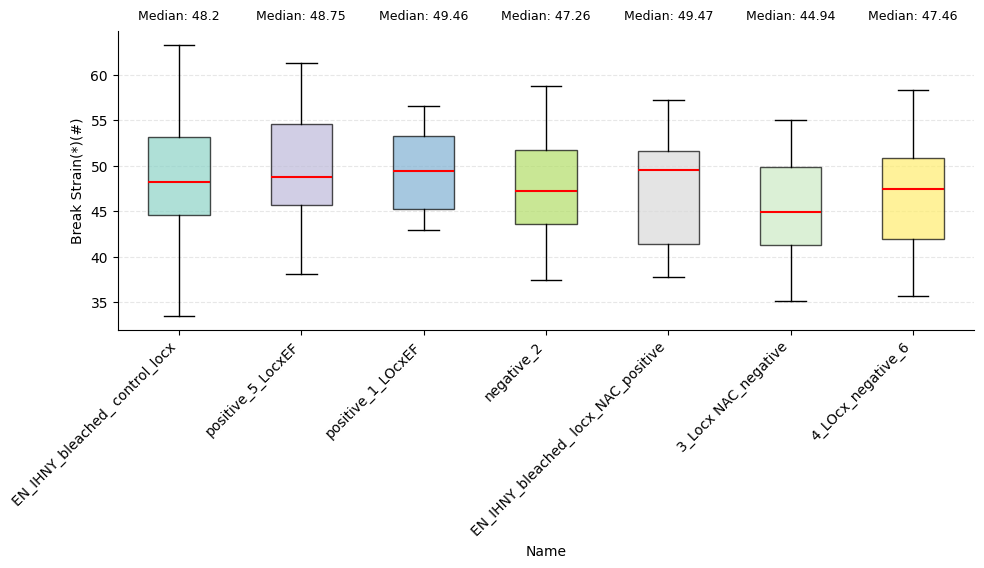

In [11]:
header = 'BREAK_STRAIN(*)(#)'
fig, ax = create_boxplot(df_merged, header)
fig.savefig(f"{savepath}{header}.png")
plt.show()

Statistical significance between EN_IHNY_bleached_ control_locx and EN_IHNY_bleached_ locx_NAC_positive: p = 0.0045
Statistical significance between positive_5_LocxEF and EN_IHNY_bleached_ locx_NAC_positive: p = 0.0359
Statistical significance between positive_1_LOcxEF and EN_IHNY_bleached_ locx_NAC_positive: p = 0.0076
Statistical significance between negative_2 and EN_IHNY_bleached_ locx_NAC_positive: p = 0.0292
Statistical significance between EN_IHNY_bleached_ locx_NAC_positive and 4_LOcx_negative_6: p = 0.0342


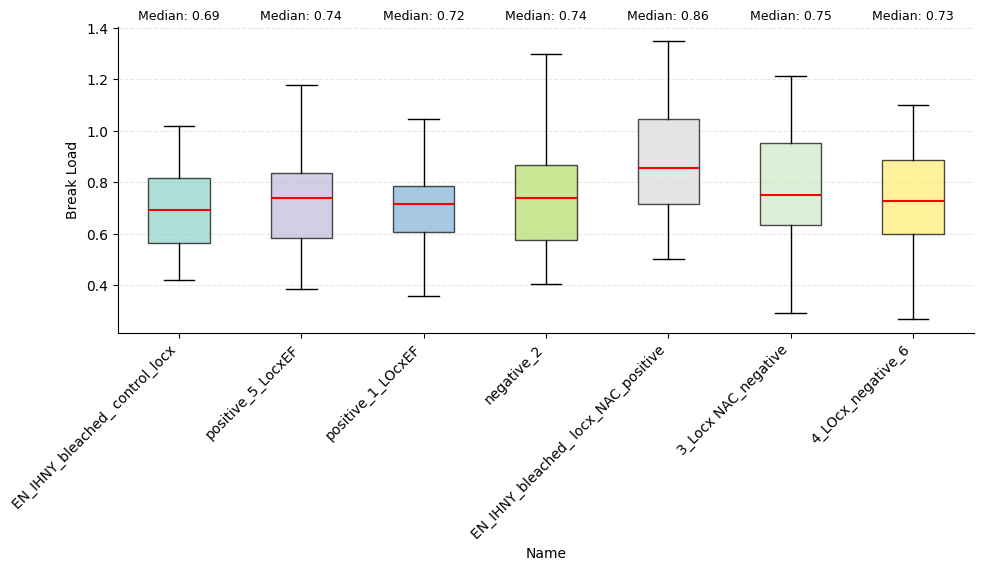

In [12]:
header = 'BREAK_LOAD'
fig, ax = create_boxplot(df_merged, header)
fig.savefig(f"{savepath}{header}.png")
plt.show()